In [1]:
import torch
import torchsummary
from torchsummary import summary
from torchvision import models

import copy
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import os
import yaml

In [2]:
import socket
if socket.gethostname()[0:4] in  ['node','holm','wats']:
    path_prefix = '/rigel/issa/users/Tahereh/Research'
elif socket.gethostname() == 'SYNPAI':
    path_prefix = '/hdd6gig/Documents/Research'
elif socket.gethostname()[0:2] == 'ax':
    path_prefix = '/home/tt2684/Research'

resultsdir = path_prefix + '/Results/Symbio/Symbio/'

In [3]:
from models import custom_models_ResNetLraveled as custom_models


In [9]:
algorithm='SLVanilla'

arche = 'AsymResLNet10F' #'FullyConnectedF' # AsymResLNet10F
archd = 'AsymResLNet10B' #'FullyConnectedB' # AsymResLNet10B
if 'FullyConnected' in arche:
        kwargs_asym = {'algorithm':algorithm, 'hidden_layers':[256, 256, 10], 'nonlinearfunc':'relu', 'input_length':1024}
else:
    kwargs_asym = {'algorithm':algorithm, 'base_channels':64, 'image_channels':3, 'n_classes':10, 'normalization_affine': True}

print(kwargs_asym)
modelF = getattr(custom_models, arche)(**kwargs_asym) #Forward().cuda() # main model
modelB = getattr(custom_models, archd)(**kwargs_asym) # backward network to compute gradients for mod

{'algorithm': 'SLVanilla', 'base_channels': 64, 'image_channels': 3, 'n_classes': 10, 'normalization_affine': True}


In [12]:
summary(modelF, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
AsymmetricFeedbackConv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
AsymmetricFeedbackConv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
AsymmetricFeedbackConv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
AsymmetricFeedbackConv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
AsymmetricFeedbackConv2d-13          [-1, 128, 16, 16]          73,728
      B

number of valid runs 0
Acc:  SLVanilla nan
Acc:  BP nan
Acc:  FA nan


/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/l

Corrd:  SLVanilla nan
Corrd:  BP nan
Corrd:  FA nan


/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: Mean of empty slice.
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: Mean of empty slice.
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tt2684/conda-envs/pytorch_tensorflow_latest/lib/python3.7/site-packages/numpy/core/_methods.py:18

Lossd:  SLVanilla nan
Lossd:  BP nan
Lossd:  FA nan


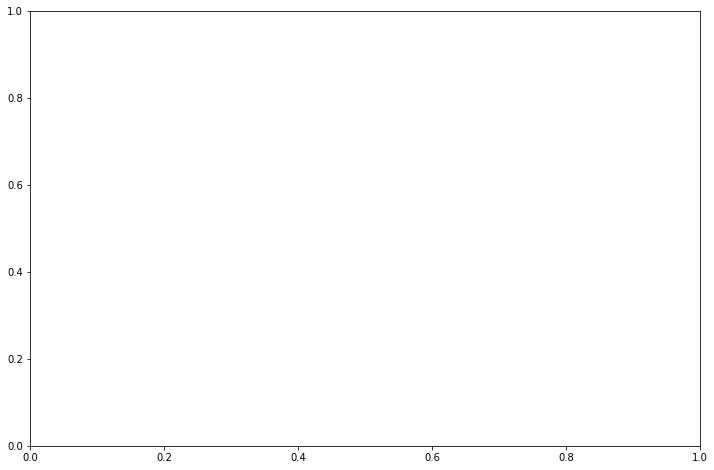

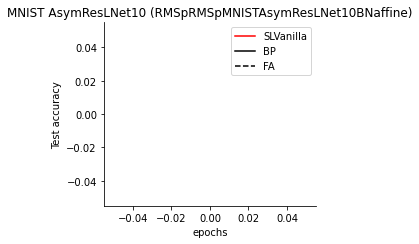

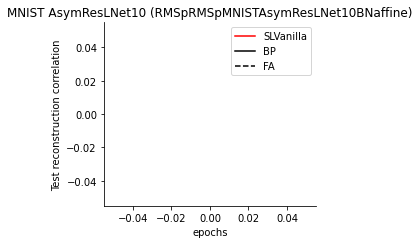

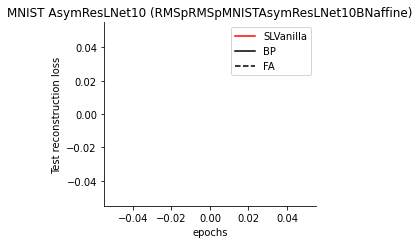

In [9]:
hashname =  'RMSpRMSpMNISTAsymResLNet10BNaffine'
#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
# 'RMSpRMSpMNISTAsymResLNet10BNaffine'
methods = ['SLVanilla','BP', 'FA']
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}
if 'AsymResLNet' in hashname:
    markers = {'FA':'o', 'BP':'o', 'SLVanilla':'o'}
elif 'FullyConn' in hashname:
    markers = {'FA':'s', 'BP':'s', 'SLVanilla':'s'}

facecolors = {'FA':'none', 'BP':'k', 'SLVanilla':'red'}

with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname) as f:
    Lines = f.readlines() 

valid_runnames = []
fig, ax = plt.subplots(1,1, figsize=(12,8))
for l in Lines:
    runname = l.strip('\n')
    
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    list_csv_paths = []
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_%s.csv'%(runname, method)
        if os.path.exists(p):
            df = pd.read_csv(p)
            if len(list(df['test_acc'])) == configs['epochs']:
                list_csv_paths.append(p)
    if len(list_csv_paths) == len(methods):
        valid_runnames.append(runname)
        configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))

print('number of valid runs',len(valid_runnames))

n_epochs = configs['epochs']
arch =  configs['arche'][:-1]

test_init = np.zeros((len(valid_runnames),n_epochs))
test_acc_dict = {}
test_corrd_dict = {}
test_lossd_dict = {}
for method in methods:
    test_acc_dict[method] = copy.deepcopy(test_init)
    test_corrd_dict[method] = copy.deepcopy(test_init)
    test_lossd_dict[method] = copy.deepcopy(test_init)
    
for r, runname in enumerate(valid_runnames):
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_%s.csv'%(runname, method)
        df = pd.read_csv(p)
        label = method 
        pl = ax.plot(df['test_corrd'], label=label, color=colors[method], ls=linestyles[method])
        test_acc_dict[method][r] = list(df['test_acc'])
        test_corrd_dict[method][r] = list(df['test_corrd'])
        test_lossd_dict[method][r] = list(df['test_lossd'])

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
measure = test_acc_dict
for method in methods:
    ax.plot(range(n_epochs ), np.median(measure[method], 0), colors[method], label=method, ls=linestyles[method])
    ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
                    np.median(measure[method], 0)+measure[method].std(0),
                    alpha=0.1, color=colors[method], ls=linestyles[method])
    print('Acc: ',method, measure[method].mean(0)[-1])
    
ax.legend()
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y', direction='out', right=False)
plt.tick_params(axis='x', direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test accuracy')
# ax.set_ylim([95,99])

ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))
plt.tight_layout()

fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_acc_%s.png'%(hashname, arch), dpi=200)
fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_acc_%s.pdf'%(hashname, arch), dpi=200)

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
measure = test_corrd_dict
for method in methods:
    ax.plot(range(n_epochs ), measure[method].mean(0), colors[method], label=method, ls=linestyles[method])
    ax.fill_between(range(n_epochs ), measure[method].mean(0)-measure[method].std(0),
                    measure[method].mean(0)+measure[method].std(0),
                    alpha=0.1, color=colors[method], ls=linestyles[method])
    print('Corrd: ', method, measure[method].mean(0)[-1])
    
ax.legend()
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y',direction='out', right=False)
plt.tick_params(axis='x',direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test reconstruction correlation')

ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))
plt.tight_layout()
fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_corrd_%s.png'%(hashname, arch), dpi=200)
fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_corrd_%s.pdf'%(hashname, arch), dpi=200)

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
measure = test_lossd_dict
for method in methods:
    ax.plot(range(n_epochs ), measure[method].mean(0), colors[method], label=method,ls=linestyles[method])
    ax.fill_between(range(n_epochs ), measure[method].mean(0)-measure[method].std(0),
                    measure[method].mean(0)+measure[method].std(0),
                    alpha=0.1, color=colors[method], ls=linestyles[method])
    print('Lossd: ' ,method, measure[method].mean(0)[-1])
    
ax.legend()
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y',direction='out', right=False)
plt.tick_params(axis='x',direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test reconstruction loss')

ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))
plt.tight_layout()
fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_loss_%s.png'%(hashname, arch), dpi=200)
fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_loss_%s.pdf'%(hashname, arch), dpi=200)